In [48]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
import numpy as np
from pygam import LogisticGAM, s
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer






try:
    from pygam import LogisticGAM
except ImportError as e:
    raise ImportError("pyGAM mangler. Kjør: pip install pygam") from e

import pandas as pd

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from pygam import s, f

In [3]:
class SKLogisticGAM(LogisticGAM):
    def predict_proba(self, X):
        p = super().predict_proba(X)
        if p.ndim == 1:
            return np.vstack([1 - p, p]).T
        return p
    def decision_function(self, X):
        return self._linear_predictor(X)

class SKLogisticGAMBalanced(SKLogisticGAM):
    def fit(self, X, y, **kwargs):
        y = np.asarray(y).astype(int)
        n = y.size
        n_pos = max(1, y.sum())
        n_neg = max(1, n - n_pos)
        w = np.where(y == 1, n / (2.0 * n_pos), n / (2.0 * n_neg))
        return super().fit(X, y, weights=w, **kwargs)


In [ ]:
# from sklearn.base import BaseEstimator, ClassifierMixin
# import numpy as np
# from pygam import LogisticGAM, s

# class MultiGAMOVR(BaseEstimator, ClassifierMixin):
#     def __init__(self, n_splines=14, lam_grid=None, max_iter=40000, tol=1e-4, verbose=False):
#         self.n_splines = n_splines
#         self.lam_grid = lam_grid if lam_grid is not None else [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1.0,10.0,100.0]
#         self.max_iter = max_iter
#         self.tol = tol
#         self.verbose = verbose
#         self.classes_ = None
#         self.models_ = None
#         self.p_ = None

#     def _make_terms(self, p):
#         terms = s(0, n_splines=self.n_splines)
#         for i in range(1, p):
#             terms += s(i, n_splines=self.n_splines)
#         return terms

#     def fit(self, X, y):
#         X = np.asarray(X)
#         y = np.asarray(y)
#         self.classes_ = np.unique(y)
#         self.p_ = X.shape[1]
#         terms = self._make_terms(self.p_)
#         self.models_ = []

#         for cls in self.classes_:
#             y_bin = (y == cls).astype(int)
#             n = y_bin.size
#             n_pos = max(1, y_bin.sum())
#             n_neg = max(1, n - n_pos)
#             w = np.where(y_bin == 1, n/(2.0*n_pos), n/(2.0*n_neg))

#             gam = LogisticGAM(terms=terms, max_iter=self.max_iter, tol=self.tol, verbose=self.verbose)
#             # robust på tvers av pyGAM-versjoner: ikke send 'progress' som kwarg
#             gam.gridsearch(X, y_bin, weights=w, lam=self.lam_grid)
#             self.models_.append(gam)
#         return self

#     def predict_proba(self, X):
#         X = np.asarray(X)
#         P = np.column_stack([m.predict_proba(X) for m in self.models_])  # (n, K)
#         s = P.sum(axis=1, keepdims=True)
#         s[s == 0] = 1.0
#         return P / s

#     def decision_function(self, X):
#         X = np.asarray(X)
#         return np.column_stack([m._linear_predictor(X) for m in self.models_])

#     def predict(self, X):
#         P = self.predict_proba(X)
#         idx = np.argmax(P, axis=1)
#         return self.classes_[idx]


In [49]:
# df_my_train_data = pd.read_csv("./student-graduation/processed/train.csv")
df_my_test_data = pd.read_csv("./student-graduation/processed/test.csv")
df_my_train_data= pd.read_csv("./student-graduation/processed/train.csv")

# df_head = df_my_train_data.head(4000)
#df = df_head.copy()  # eller bruk hele df_my_data i stedet for head(800)
df_train = df_my_train_data.copy()  # eller bruk hele df_my_data i stedet for head(800)
le = LabelEncoder()
df_train['Target'] = le.fit_transform(df_train['Target'])
df_test = df_my_test_data.copy()  # eller bruk hele df_my_data i stedet for head(800)
df_test['Target'] = le.fit_transform(df_test['Target'])

In [ ]:


from sklearn.naive_bayes import GaussianNB, MultinomialNB


def get_model_and_params(model_type):
    model_type = str(model_type).strip().lower()

    if model_type == "random_forest":
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        param_grid = {
            'model__n_estimators': [100, 300],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5]
        }
        print('model = random_forest')
    elif model_type == "svm":
        model = SVC(random_state=42)
        param_grid = {
            'model__C': [ 10.5, 11, 11.2, 10.8, 11.5],
            'model__kernel': ['linear','rbf','poly', 'sigmoid'],
            'model__gamma': ['scale', 'auto']
        }
        print('model = svm')
    elif model_type in ("neural_net", "mlp"):
        model = MLPClassifier(random_state=42, max_iter=1000, validation_fraction=0.20,n_iter_no_change=20,early_stopping=True, solver='adam',     )
        param_grid = {
            'model__hidden_layer_sizes': [(64,), (128,128), (256)],
            'model__alpha': [1e-4, 1e-3, 1e-2],
            'model__learning_rate_init': [1e-3, 1e-2],
            'model__activation': ['relu', 'tanh']
        }
        print('model = neural_net')
    elif model_type in ("logistic", "logreg", "logistic_regression"):
        model = LogisticRegression(max_iter=2000)
        # Bruk liste av grids for å unngå inkompatible kombinasjoner av solver/penalty
        param_grid = [
            {   # LBFGS: bare L2
                'model__solver': ['lbfgs'],
                'model__penalty': ['l2'],
                'model__C': [0.01, 0.1, 1, 10],
                'model__class_weight': [None, 'balanced']
            },
            {   # liblinear: L1/L2, ovr
                'model__solver': ['liblinear'],
                'model__penalty': ['l1', 'l2'],
                'model__C': [0.01, 0.1, 1, 10],
                'model__class_weight': [None, 'balanced']
            },
            {   # saga: L1/L2, skalerer godt på større datasett
                'model__solver': ['saga'],
                'model__penalty': ['l1', 'l2'],
                'model__C': [0.01, 0.1, 1, 10],
                'model__class_weight': [None, 'balanced']
            }
        ]
    elif model_type == "dt":
        model = DecisionTreeClassifier(random_state=42)
        param_grid = {
            'model__min_samples_leaf': [10, 20, 30],
            "model__min_impurity_decrease": [0.0, 1e-4, 1e-3],
            'model__min_weight_fraction_leaf' :[0.0],
            "model__max_features": [None, "sqrt", "log2"],
            # "model__max_leaf_nodes": [63, 127],
            'model__min_samples_split':[2, 5, 7, 10],
            # splitter-strategi
            "model__splitter": ["best", "random"],
            # kostnad-kompleksitets-beskjæring
            "model__ccp_alpha": [0.0, 1e-3,],
            # håndter ev. ubalanse
            "model__class_weight": [None, "balanced"],
            'model__criterion': ['gini', 'entropy', 'log_loss'],
            'model__max_depth': [5, 10, 12, 15, 18],
            "model__min_impurity_decrease": [0.0, 1e-4, 1e-3],
        }
        print("model = decision_tree")
    elif model_type in ("nb", "naive_bayes", "gaussian_nb"):
        model = GaussianNB()
        param_grid = {}  # har egentlig ingen viktige hyperparametre å tune
        print("model = gaussian_nb")
    else:
        raise ValueError("Ukjent modelltype")
    return model, param_grid

def run_pipeline(data_train: pd.DataFrame, data_test: pd.DataFrame, target_column: str, model_type: str):
    if target_column not in data_train.columns:
        raise ValueError(f"Målkolonnen '{target_column}' finnes ikke i data.")

    X_train = data_train.drop(columns=[target_column])
    y_train = data_train[target_column]

    X_test = data_test.drop(columns=[target_column])
    y_test = data_test[target_column]


    # Konservativ CV basert på minste klassefrekvens
    min_class_count = pd.Series(y_train).value_counts().min()
    cv = int(min(5, max(2, min_class_count)))

    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=0.2, random_state=42, stratify=y
    # )

    model, param_grid = get_model_and_params(model_type)

    
    if isinstance(model, MultinomialNB):
        steps = [
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('model', model)
        ]
    else:
        steps = [
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler(with_mean=False) if scipy.sparse.issparse(X_train) else StandardScaler()),
            ('model', model)
        ]
    pipeline = Pipeline(steps)
    grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            refit=True,
            error_score='raise'
        )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print("✅ Beste parametere:", grid_search.best_params_)
    print("📊 Test accuracy:", acc)
    return best_model



In [7]:
# try:
#     _ = LogisticGAM  # referanse fra import-cellen
# except NameError:
#     raise ImportError("pyGAM ikke importert. Kjør import-cellen på nytt eller installer: python -m pip install pygam")

In [60]:
# Mulige modeller å kjøre: "random_forest", "svm", "neural_net, "logreg", "dt"
#Det må gjøres tuning på additive modellen for få noen resultater, så den er ikke ferdig enda, men de andre modelle fungerer.
model = run_pipeline(df_train, df_test, target_column='Target', model_type='nb')


model = gaussian_nb
✅ Beste parametere: {}
📊 Test accuracy: 0.6103074141048824


In [51]:
# Kjør dette i en ny celle for å se forskjellene
print("Train columns:", df_train.drop(columns=['Target']).columns.tolist())
print("\nTest columns:", df_test.drop(columns=['Target']).columns.tolist())
print("\nColumns only in train:", set(df_train.columns) - set(df_test.columns))
print("Columns only in test:", set(df_test.columns) - set(df_train.columns))

Train columns: ['Application order', 'Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP', 'Marital status_1', 'Marital status_2', 'Application mode_1', 'Application mode_4', 'Application mode_8', 'Application mode_12', 'Application mode_14', 'Application mode_15', 'Course_2', 'Course_3', 'Course_4', 'Course_5', 'Course_6', 'Course_7', '

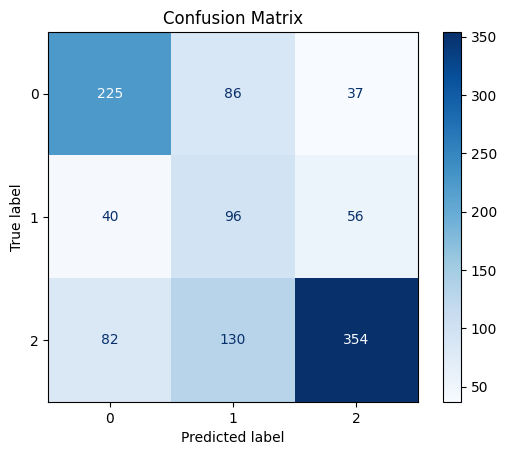

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

actual = df_test['Target']
predicted = model.predict(df_test.drop(columns=['Target']))

confusion_matrix = metrics.confusion_matrix(actual, predicted)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [189]:
X_train = df_train.drop(columns=['Target'])
y_train = df_train['Target']

X_test = df_test.drop(columns=['Target'])
y_test = df_test['Target']


print(pd.Series(y_train).value_counts(normalize=True))  # ubalanse?
# Baseline: hvor ille er "alltid største klasse"?
major = pd.Series(y_test).value_counts().idxmax()
print("Majoritets-baseline:", (y_test == major).mean())

Target
2    0.499322
0    0.321203
1    0.179476
Name: proportion, dtype: float64
Majoritets-baseline: 0.5


In [158]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

baseline = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler()),
    ("lr", LogisticRegression(max_iter=2000, class_weight="balanced", multi_class="ovr"))
])
baseline.fit(X_train, y_train)
y_pred_bl = baseline.predict(X_test)
from sklearn.metrics import balanced_accuracy_score
print("LR balanced acc:", balanced_accuracy_score(y_test, y_pred_bl))

LR balanced acc: 0.6783264328865499


C:\Users\peder\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [194]:
import pandas as pd

threshold = 0.7

# 1. Beregn korrelasjonsmatrisen
corr = df_train.corr()

# 2. Lag en maske: vi vil ha |corr| > threshold, og ikke med diagonalen (1.0)
mask = (corr.abs() > threshold) & (corr.abs() < 1)

# 3. Bruk where + stack for å hente ut kun de gyldige parene
filtered = corr.where(mask).stack().reset_index()

# 4. Gi kolonnene fornuftige navn
filtered.columns = ["feature_1", "feature_2", "correlation"]

# 5. Sorter etter styrken på korrelasjonen
filtered = filtered.reindex(
    filtered["correlation"].abs().sort_values(ascending=False).index
)

# --- NØKKELDELEN: tving full utskrift ---
# Sett max_rows til minst så mange rader som du faktisk har
pd.set_option("display.max_rows", filtered.shape[0] + 1)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# Bruk to_string for å unngå Jupyter/IDE sin HTML-truncation
print(filtered.to_string(index=False))


                             feature_1                              feature_2  correlation
   Curricular units 1st sem (credited)    Curricular units 2nd sem (credited)     0.944811
   Curricular units 2nd sem (credited)    Curricular units 1st sem (credited)     0.944811
   Curricular units 2nd sem (enrolled)    Curricular units 1st sem (enrolled)     0.942627
   Curricular units 1st sem (enrolled)    Curricular units 2nd sem (enrolled)     0.942627
                         International                            Nacionality     0.911724
                           Nacionality                          International     0.911724
   Curricular units 2nd sem (approved)    Curricular units 1st sem (approved)     0.904002
   Curricular units 1st sem (approved)    Curricular units 2nd sem (approved)     0.904002
      Curricular units 1st sem (grade)       Curricular units 2nd sem (grade)     0.837170
      Curricular units 2nd sem (grade)       Curricular units 1st sem (grade)     0.837170